In [1]:
using PyPlot
using DSP
using QuadGK

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [2]:
const t = 0.5
U = 4.2
T = 10.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-8.0,8.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.50;
kB = 8.617333262145e-5;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("cubic",t,ω);

  0.589699 seconds (1.74 M allocations: 123.460 MiB, 6.17% gc time)


In [5]:
function hartreefock(ω,dos,nωn,nω,U,T,zeroplus,tol,mix,itermax)
        gloc = zeros(ComplexF64,nω,2)

        #for paramagnetic
        magnet = 0.0

        nf = fermi.(ω,T)

        ρr = D0ω[1:4:nω]
        wr  = ω[1:4:nω]

        Σ1 = U .* [0.8 -0.8]

        @fastmath @inbounds for iω in 1:nω
        ζ_up = ω[iω] + im * zeroplus - Σ1[1]
        ζ_down = ω[iω] + im * zeroplus - Σ1[2]

        intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
        sum = trapz(wr,intg)   

        gloc[iω,1] = sum * ζ_down
        gloc[iω,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)    

            #calculate ncalc for each band (gloc↑ and gloc↓ )
            ncalc = zeros(Float64,2)
            @fastmath @inbounds for i in 1:2
                ncalc[i] = -1/π .* trapz(ω,imag(gloc[:,i]) .* nf)
            end
            #calculate Σcalc with half-filling shift μ = U/2 * (n↑ + n↓ )            
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)

           @fastmath @inbounds for iω in 1:nω
                ζ_up = ω[iω] + im * zeroplus - Σ1[1]
                ζ_down = ω[iω] + im * zeroplus - Σ1[2]

                intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
                sum = trapz(wr,intg)   

                gloc[iω,1] = sum * ζ_down
                gloc[iω,2] = sum * ζ_up
            end

            #convergent checking
            convg, error = convergent(gloc_old,gloc,ω,nω,tol)
        
            #final conditions
            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved, need more tuning on mixing parameter or number of iterations!")
                break
            elseif convg == true
                println("Convergent is achieved")
                break
            end
        
        end #end selfcons

        return gloc,magnet

end;

In [6]:
T = 0.0
Us = range(0.8,length=4,step=0.8)
Us = convert(Array{Float64},Us)

glocU = zeros(ComplexF64,nω,2,length(Us))
magnetU = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    glocU[:,:,iU],magnetU[iU] = hartreefock(ω,D0ω,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved


In [7]:
U = 1.5
Ts = [0.0, 1600., 1800., 2000.,]
Ts = convert(Array{Float64},Ts)

glocT = zeros(ComplexF64,nω,2,length(Ts))
magnetT = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    glocT[:,:,iT],magnetT[iT] = hartreefock(ω,D0ω,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved


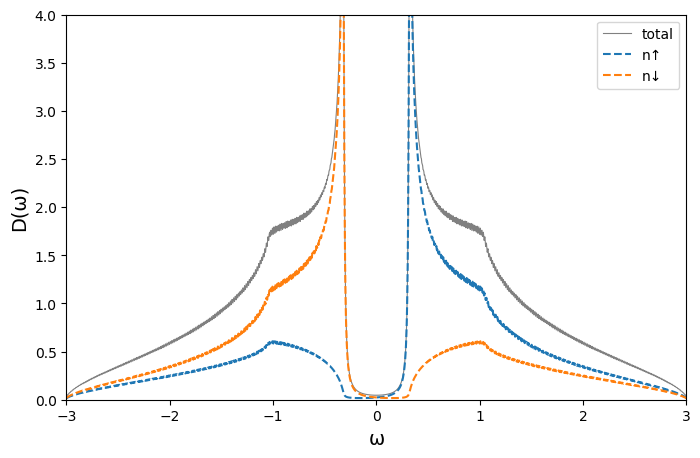

In [8]:
plt.figure(figsize=(8,5))
plt.plot(ω,-imag(sum(glocU[:,:,2],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,-imag(glocU[:,1,2]),"--",label="n↑")
plt.plot(ω,-imag(glocU[:,2,2]),"--",label="n↓")
plt.xlim(-3,3)
plt.ylim(0,4)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)
plt.legend()

plt.show()
plt.savefig("dosupdown_MF_AF.pdf",format="pdf")

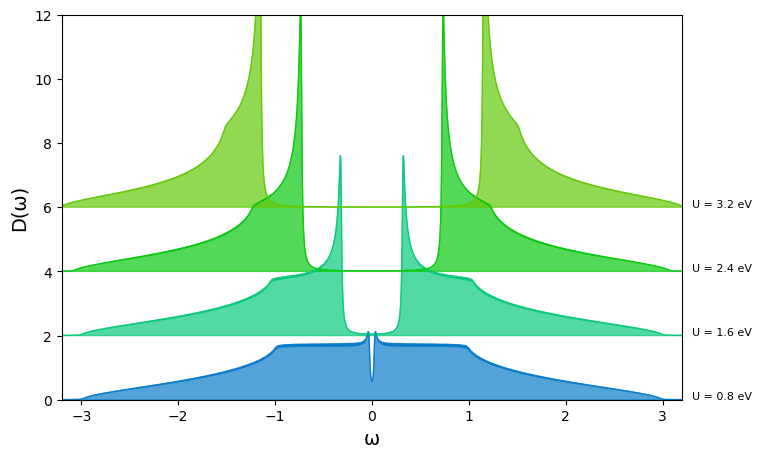

In [9]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9","#0AC97C","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iU,U) in enumerate(Us)
    plt.plot(ω,-imag(sum(glocU[:,:,iU],dims=2)) .+ 2.0*(iU - 1),color=color[iU],linewidth=0.8)
    plt.text(3.3,(iU-1)*2.0,"U = $U eV",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocU[:,:,iU],dims=2)).+ (iU-1)*2.0),(iU-1)*2.0,alpha=0.7,color=color[iU])
end
plt.xlim(-3.2,3.2)
plt.ylim(0,12)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolUDOS_MF_AF.pdf",format="pdf")

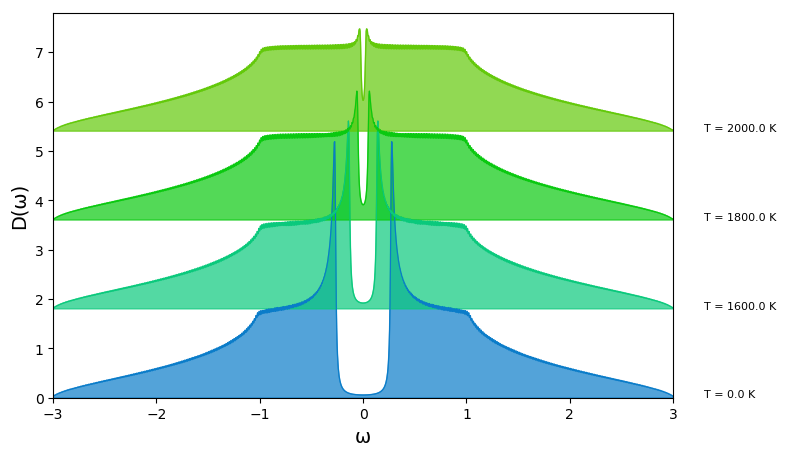

In [10]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9","#0AC97C","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iT,T) in enumerate(Ts)
    plt.plot(ω,-imag(sum(glocT[:,:,iT],dims=2)) .+ 1.8*(iT - 1),color=color[iT],linewidth=0.8)
    plt.text(3.3,(iT-1)*1.8,"T = $T K",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocT[:,:,iT],dims=2)).+ (iT-1)*1.8),(iT-1)*1.8,alpha=0.7,color=color[iT])
end
plt.xlim(-3.0,3.0)
plt.ylim(0,7.8)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolTDOS_MF_AF.pdf",format="pdf")

In [11]:
Us = range(0.8,length=20,step=0.3)
Us = convert(Array{Float64},Us)

glocUs = zeros(ComplexF64,nω,2,length(Us))
magnetUs = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    glocUs[:,:,iU],magnetUs[iU] = hartreefock(ω,D0ω,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved


In [12]:
U = 2.0

Ts = range(0.0,length=20,stop = 5000.)
Ts = convert(Array{Float64},Ts)

glocTs = zeros(ComplexF64,nω,2,length(Ts))
magnetTs = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    glocTs[:,:,iT],magnetTs[iT] = hartreefock(ω,D0ω,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved
Convergent is achieved


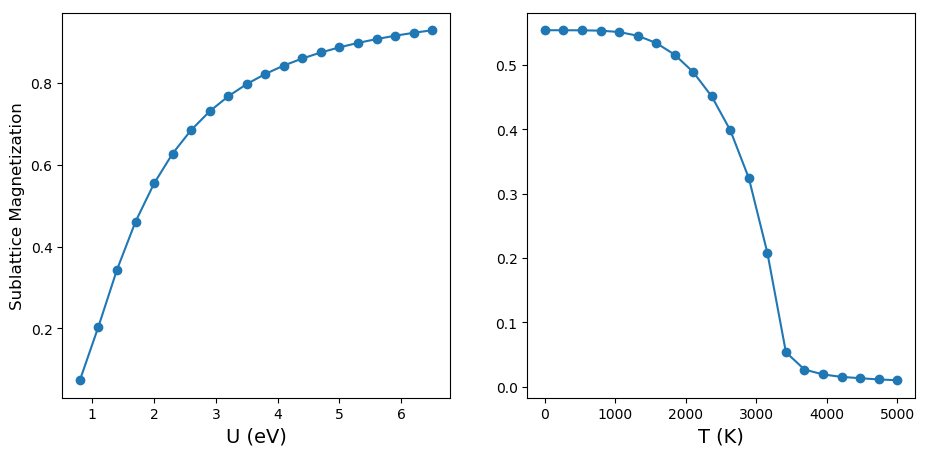

In [13]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(Us,magnetUs,"-o")
plt.ylabel("Sublattice Magnetization",fontsize=12)
plt.xlabel("U (eV)",fontsize=14)

plt.subplot(1,2,2)
plt.plot(Ts,magnetTs,"-o")
plt.xlabel("T (K)",fontsize=14)

plt.show()
plt.savefig("magnetization_MF_AF.pdf",format="pdf")